In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Polygon, ConnectionPatch

from mpl_toolkits.axes_grid1 import make_axes_locatable

from blg_strain.utils.saver import load
from blg_strain.lattice import StrainedLattice, brillouin_zone
from blg_strain.bands import BandStructure, FilledBands, get_bands
from blg_strain.macroscopic import integrand_by_parts
from blg_strain.utils.const import q, hbar, muB, a0, hbar_J, mu0

gr = (5**.5 + 1) / 2
width_in = 3.375  # column width in inches

In [2]:
# mpl.font_manager._rebuild()

In [3]:
# %matplotlib notebook

In [4]:
mpl.rc_file('sBLG.rc')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [5]:
pcolormesh_params = dict(rasterized=True, shading='gouraud')

In [6]:
def savefig(fig, filename, columns=1, dpi=400, tweak_height=1):
    assert columns in [1, 1.5, 2]
    width = 3.375 * columns  # width in inches
    
    # get the center of the plot area
    x0, y0, w, h = [fig.bbox.bounds[i]/100 for i in range(4)]
    xcenter = x0 + w/2
    ycenter = y0 + h/2
    
    # bbox that is the width of the specified number of columns and with an automatic height
    bbox = mpl.transforms.Bbox.from_bounds(xcenter - width/2, y0, width, h * tweak_height)
    
    fig.savefig(filename, bbox_inches=bbox, transparent=True, dpi=dpi)

# FigureKspace - Brillouin Zone and magnetic moment

In [7]:
eps = 0.01
theta = 0
Delta = 0.007  # eV
EF = 0.007  # eV

cmap='cividis'

In [8]:
sl = StrainedLattice(eps, theta)
sl.calculate()

sl0 = StrainedLattice(0, 0)
sl0.calculate()

bs = BandStructure(sl, Delta=Delta)
bs.calculate(600, 600)

fb = FilledBands(bs, EF=EF)
fb.calculate(600, 600)

In [9]:
K = 4 * np.pi / (3 * np.sqrt(3))
kxa = np.linspace(-1.2 * K, 1.2 * K, 500)
kya = kxa
Kxa, Kya = np.meshgrid(kxa, kya)

In [10]:
E, Psi = get_bands(Kxa, Kya, sl, Delta=Delta)

In [11]:
bz0 = brillouin_zone(sl0.strain)
bz = brillouin_zone(sl.strain)

M = bs.Mu[2] + q * bs.Omega[2] / hbar * (EF - bs.E[2])
M = M / muB  # A * m^2 -> Bohr magnetons
dM = integrand_by_parts(bs.kxa, bs.kya, bs.splE[2], bs.splO[2], bs.splM[2], EF=EF)
prefactor = - a0 * q * mu0 / (hbar_J) / (2 * np.pi * a0) ** 2
dM = dM / prefactor / muB / np.sqrt(3) # A * m^2 / a0 -> Bohr magnetons / a

In [28]:
labels = cax.get_xticklabels()
labels[0]

Text(0.0, 1, '$\\mathdefault{-10^{5}}$')

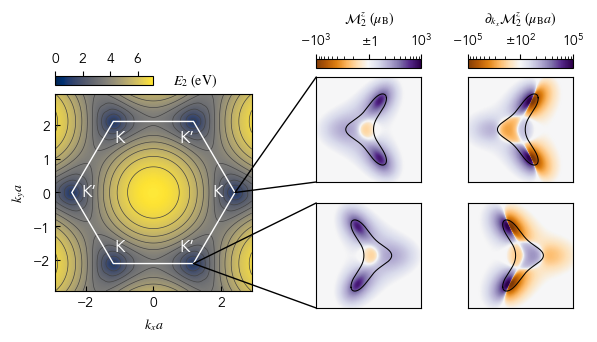

In [29]:
fig = plt.figure(figsize=(2*width_in, 3))
# Fake axes to define area spanned by all subplots
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)

gs = fig.add_gridspec(2, 5, width_ratios=[1.7, .2, 1, 0, 1])
ax0 = fig.add_subplot(gs[:, 0])
ax02 = fig.add_subplot(gs[0, 2])
ax12 = fig.add_subplot(gs[1, 2])
ax04 = fig.add_subplot(gs[0, 4])
ax14 = fig.add_subplot(gs[1, 4])

# Full BZ
im = ax0.pcolormesh(Kxa, Kya, E[2], **pcolormesh_params, cmap=cmap, vmin=0)
ax0.contour(Kxa, Kya,  E[2], colors='#444444', levels=10, linewidths=0.5, alpha=1)
ax0.set_aspect('equal')

ax0.set_xlabel(r'$k_xa$')
ax0.set_ylabel(r'$k_ya$')

# Draw Brillouin zone
p = Polygon(bz, fill=False, color='w', lw=1, zorder=10) # zorder=10 to put on top
ax0.add_patch(p)

# # Draw box around K point
# p = Polygon([sl.K + [0.05, 0.05], sl.K + [-0.05, 0.05], sl.K + [-0.05, -0.05], sl.K + [0.05, -0.05]], fill=False, color='k', lw=0.5, ls='--', zorder=11)
# ax0.add_patch(p)


# Draw "zoom in" to K/K'
cp1 = ConnectionPatch(sl.K, (0, 1), "data", "axes fraction", axesA=ax0, axesB=ax02, zorder=20)
cp2 = ConnectionPatch(sl.K, (0, 0), "data", "axes fraction", axesA=ax0, axesB=ax02, zorder=20)
ax0.add_artist(cp1)
ax0.add_artist(cp2)
cp1 = ConnectionPatch(sl.bz[1], (0, 1), "data", "axes fraction", axesA=ax0, axesB=ax12, zorder=20)
cp2 = ConnectionPatch(sl.bz[1], (0, 0), "data", "axes fraction", axesA=ax0, axesB=ax12, zorder=20)
ax0.add_artist(cp1)
ax0.add_artist(cp2)

# K, K' labels
ax0.text(1, -1.6, 'K’', color='w', size=12, va='center', ha='center')
ax0.text(1, 1.6, 'K’', color='w', size=12, va='center', ha='center')
ax0.text(-1, -1.6, 'K', color='w', size=12, va='center', ha='center')
ax0.text(-1, 1.6, 'K', color='w', size=12, va='center', ha='center')
ax0.text(1.9, 0, 'K', color='w', size=12, va='center', ha='center')
ax0.text(-1.9, 0, 'K’', color='w', size=12, va='center', ha='center')

## colorbar
l, b, w, h = ax0.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w/2, .03])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cax.tick_params(direction='out')
cax.xaxis.set_ticks_position('top')
cax.yaxis.set_label_position("right")
cax.text(1.2, 0.5, '$E_2\ (\mathrm{eV})$', transform=cax.transAxes, va='center')
cbar.set_ticks([0, 2, 4, 6])

# K and K' - M
norm_M=mpl.colors.SymLogNorm(linthresh=1, linscale=0, vmin=-1e3, vmax=1e3)
im02 = ax02.pcolormesh(bs.Kxa, bs.Kya, M, **pcolormesh_params, cmap='PuOr', norm=norm_M)
ax12.pcolormesh(-bs.Kxa, -bs.Kya, M, **pcolormesh_params, cmap='PuOr', norm=norm_M)

# K and K' - dM
norm_dM=mpl.colors.SymLogNorm(linthresh=1e2, linscale=0,  vmin=-1e5, vmax=1e5)
im04 = ax04.pcolormesh(bs.Kxa, bs.Kya, dM, **pcolormesh_params, cmap='PuOr', norm=norm_dM)
ax14.pcolormesh(-bs.Kxa, -bs.Kya, -dM, **pcolormesh_params, cmap='PuOr', norm=norm_dM)
# dM picks up a negative sign in K' because the derivative does not undergo spatial inversion


# E=EF contours
ax02.plot(fb.contours[2][0][:,0], fb.contours[2][0][:,1], 'k')
ax12.plot(-fb.contours[2][0][:,0], -fb.contours[2][0][:,1], 'k')
ax04.plot(fb.contours[2][0][:,0], fb.contours[2][0][:,1], 'k')
ax14.plot(-fb.contours[2][0][:,0], -fb.contours[2][0][:,1], 'k')

for a in [ax02, ax12, ax04, ax14]:
    x0, x1 = a.get_xlim()
    y0, y1 = a.get_ylim()
    a.set_xlim((x0 + x1) / 2 - (x1 - x0) / 4, (x0 + x1) / 2 + (x1 - x0) / 4)
    a.set_ylim((y0 + y1) / 2 - (y1 - y0) / 4, (y0 + y1) / 2 + (y1 - y0) / 4)
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect('equal')
    
    
## colorbar M
l, b, w, h = ax02.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w, .03])
cbar = plt.colorbar(im02, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\mathcal{M}^z_2\ (\mu_{\mathrm{B}})$', labelpad=8)
# cax.text(1.2, 0.5, r'$\mathcal{M}^z_2$ ($\mu_{\mathrm{B}}$)', transform=cax.transAxes, va='center')
cbar.set_ticks([-1e3, 0, 1e3])
labels = cax.get_xticklabels()
labels[1] = '$\\mathdefault{\pm1}$'
cax.set_xticklabels(labels)
values = np.arange(2,10)**3
minorticks = norm_M(1 * np.concatenate((-values[::-1], values))) # Log-spaced ticks from 1 to 10^3
cax.xaxis.set_ticks(minorticks, minor=True)
    
## colorbar dM
l, b, w, h = ax04.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w, .03])
cbar = plt.colorbar(im04, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\partial_{k_x}\mathcal{M}^z_2\ (\mu_{\mathrm{B}}a)$', labelpad=8)
# cax.text(1.2, 0.5, r'$\partial_{k_x}\mathcal{M}^z_2$ ($10^3$ $\mu_{\mathrm{B}}/a$)', transform=cax.transAxes, va='center')
cbar.set_ticks([-1e5, 0, 1e5])
labels = cax.get_xticklabels()
labels[1] = '$\\mathdefault{\pm10^2}$'
cax.set_xticklabels(labels)
values = np.arange(2,10)**3
minorticks = norm_dM(1e2 * np.concatenate((-values[::-1], values))) # Log-spaced ticks from 10^2 to 10^5
cax.xaxis.set_ticks(minorticks, minor=True);

In [30]:
savefig(fig, 'FigureKspace.pdf', 2, tweak_height=1.1)

# FigureSusc - susceptibility versus Delta, EF